In [1]:
import numpy as np
import pickle as pkl
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from aidam.miscellanea_utils import find_matlabstyle
from scipy.optimize import curve_fit

from aidam.faga.faga import Faga
from aidam.faga.init_functions_repo import uniform_init
from aidam.faga.terminal_functions_repo import TF_max_generations
from aidam.faga.recomb_functions_repo import constant_recombination_rates
from aidam.faga.selection_functions_repo import tophalf_selection, ranking_selection
from aidam.faga.crossover_functions_repo import real_averaging_crossover, weighted_averaging_crossover
from aidam.faga.mutation_functions_repo import random_mutation_in_range, local_mutation_in_range

from aidam.math_utils import moving_function_rev1

## Lettura dati

In [2]:
data_file='stored_data.pkl'

infile=open(data_file,'rb')
trend=pkl.load(infile)
regioni=pkl.load(infile)
giorni=pkl.load(infile)
giorno_settimana=pkl.load(infile)
infile.close()

day_counter=list(range(len(giorni)))

print('Giorni osservati: %d'%len(giorni))
print('Primo giorno: %s'%giorni[0])
print('Ultimo giorno: %s'%giorni[-1])

Giorni osservati: 71
Primo giorno: 2020-02-24T18:00:00
Ultimo giorno: 2020-05-04T17:00:00


Preparazione date

- creo il giorno0 nel formato *datetime* per poi creare i nuovi plot su questa base
- creo una lista di giorni (in formato di stringhe) partendo dal giorno0

In [3]:
giorno0=datetime.strptime(giorni[0][0:10], "%Y-%m-%d")
str_giorni=[]
for d in range(500):
    str_giorni.append((giorno0+timedelta(d)).strftime("%Y-%m-%d"))
str_giorni=np.array(str_giorni)

oggi=datetime.strftime(datetime.now(), "%Y-%m-%d")
indice_oggi=find_matlabstyle(str_giorni,lambda x:x==oggi)[0]

## Funzioni base

In [4]:
def generalized_sigmoid(t,a,b,M,alpha):
    y=M/(1+np.exp(-a*t+b))**alpha
    return y

def generalized_sigmoid_ext(t,a,b,c,M,alpha):
    y=(M+c*t)/(1+np.exp(-a*t+b))**alpha
    return y

### Plot di test

In [5]:
t=np.arange(0,30)
y=list(map(lambda x:generalized_sigmoid(x,a=1,b=2,M=200,alpha=1.5),t))

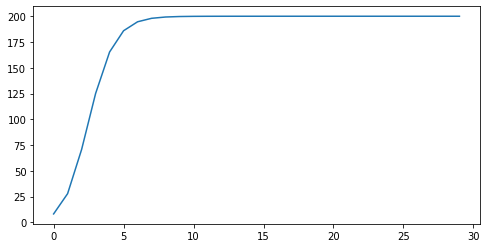

In [6]:
fig,ax=plt.subplots(1,1,figsize=(8,4))
ax.plot(t,y)

## Fitting

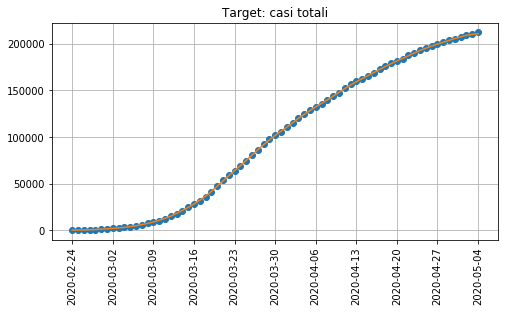

In [7]:
target_data=trend['totale_casi']['Italia']
target_data_filtered=moving_function_rev1(target_data,np.mean,2,2)

fig,ax=plt.subplots(1,1,figsize=(8,4))
ax.plot(day_counter,target_data,'o')
ax.plot(day_counter,target_data_filtered,'-')
ax.set_xticks(list(range(0,len(target_data),7)))
ax.set_title('Target: casi totali')
ax.set_xticklabels(str_giorni[list(range(0,len(target_data),7))],rotation=90)
ax.grid()

## GA

### Setup genetico

- popolazione iniziale
- operatori GA
- fitness function

In [15]:

pop_cardinality=100
days_training=len(target_data)


a_range=[0,0.25]
b_range=[0, 1e-5]
c_range=[0,10]
M_range=[2e+5,3e+5]
alpha_range=[0,10]


dominio=np.vstack((a_range,
                   b_range,
                   c_range,
                   M_range,
                   alpha_range))
dominio=dominio.T

In [16]:
#   Popolazione iniziale
initial_population=uniform_init(pop_cardinality,5,
                             dominio[0,:],
                             dominio[1,:])


#    termination
def custom_termination(gao):
    return TF_max_generations(gao,400)


#   recombination
def basic_recombination(gao):
    return constant_recombination_rates(gao,[0.2, 0.8, 0.08])

#   mutazione
def custom_mutation(chromosome_index,gao):
    return random_mutation_in_range(chromosome_index,gao,dominio.T,num_mutations=1)

xy_data=(np.arange(days_training),
         target_data[0:days_training])

#   fitness
def approximation_fitness(candidates):
    evals=np.zeros(candidates.shape[0])
    for icand,c in enumerate(candidates):
        #   calcolo l'errore
        err=[]
        for isamp,xi in enumerate(xy_data[0]):
            err.append(np.abs(xy_data[1][isamp]-generalized_sigmoid_ext(xi,*c)))
        #   setto la fitness in modo che sia più alta per errori più piccoli
        evals[icand]=1/(np.mean(err)+np.percentile(err,90))
    return evals


ganedo=Faga(initial_population,
                     fitness_fun=approximation_fitness,                 
                     selection_fun=tophalf_selection,
                     crossover_fun=weighted_averaging_crossover,
                     mutation_fun=custom_mutation,
                     termination_fun=custom_termination,
                     recomb_rates_fun=basic_recombination,
                     elite=2,
                     verbose=False,
                     print_info=50)

# la soluzione corrente la metto in lista
solution,performance=ganedo.solve()


print(solution)

Gen:     0 BestAll: 6.563e-05 BestGen: 6.563e-05  BioDiv: 5.7e+03
Gen:    50 BestAll: 0.0001641 BestGen: 0.0001641  AveFit: 0.000154
Gen:   100 BestAll: 0.0001654 BestGen: 0.0001654  AveFit: 0.0001575
Gen:   150 BestAll: 0.0001654 BestGen: 0.0001654  AveFit: 0.0001621
Gen:   200 BestAll: 0.0001654 BestGen: 0.0001654  AveFit: 0.000161
Gen:   250 BestAll: 0.0001654 BestGen: 0.0001654  AveFit: 0.0001591
Gen:   300 BestAll: 0.0001693 BestGen: 0.0001693  AveFit: 0.0001596
Gen:   350 BestAll: 0.0001703 BestGen: 0.0001703  AveFit: 0.0001649
Gen:   400 BestAll: 0.0001703 BestGen: 0.0001703  AveFit: 0.000164
[6.42159221e-02 9.69544062e-06 9.99143100e+00 2.30174602e+05
 8.67796036e+00]


Adesso applico il modello tunato sia ai giorni passati sia a giorni futuri.

*forecast_days* sono i giorni per cui lo applico: iniziano dal giorno 0 e finoscono quando si vuole nel futuro

In [17]:
forecast_days=np.arange(200)
y_pred=np.array(list(map(lambda x:generalized_sigmoid_ext(x,*solution),forecast_days)))

#### Plots

In [18]:
# preparazione palette colori
lista_colori=list(mcolors.TABLEAU_COLORS.items())
color_names=[cn[0] for cn in lista_colori]

C:\Users\klaat\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


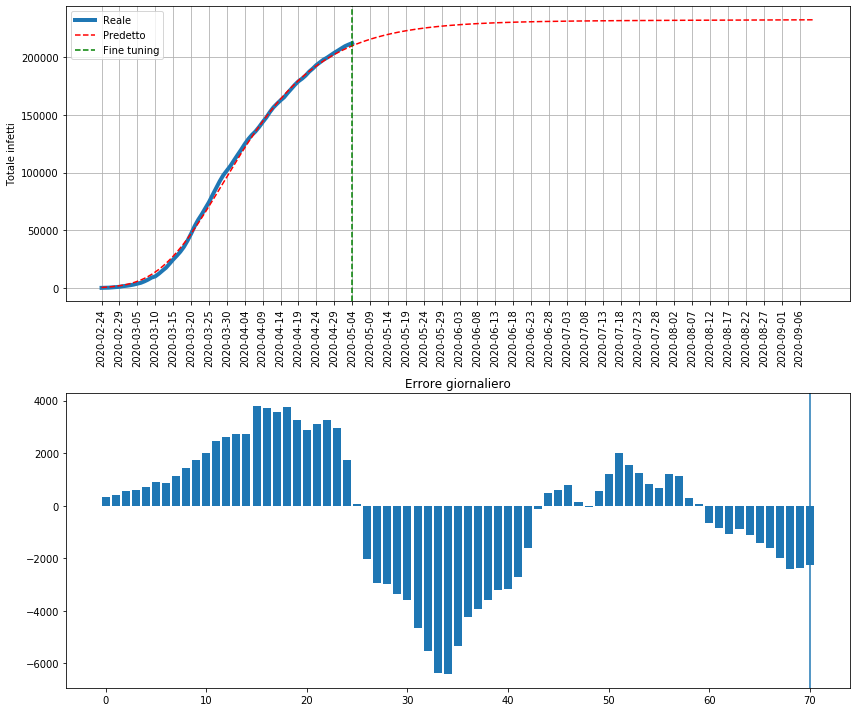

In [19]:
fig,ax=plt.subplots(2,1,figsize=(12,10))
ax[0].plot(day_counter,target_data,label='Reale',linewidth=4)
ax[0].plot(forecast_days,y_pred,'r--',label='Predetto')
ax[0].axvline(days_training-1,c='g',ls='--',label='Fine tuning')
ax[0].set_xticks(list(range(0,len(forecast_days),5)))
ax[0].set_xticklabels(str_giorni[list(range(0,len(forecast_days),5))],rotation=90)
ax[0].set_ylabel('Totale infetti')
ax[0].legend()
ax[0].grid()

ax[1].bar(day_counter,y_pred[day_counter]-target_data)
ax[1].axvline(days_training-1)
ax[1].set_title('Errore giornaliero')
fig.tight_layout()
fig.show()

### Adesso vediamo, secondo il modello, quando non avremo più contagiati

In [20]:
nuovi_contagi_pred=np.diff(y_pred)

nuovi_contagi_reali=np.diff(target_data)
nuovi_contagi_reali_filtered=np.diff(target_data_filtered)


soglie_contagi=[1000,500,100]
giorni_soglia=[]
for soglia in soglie_contagi:
    nuovi_contagi_sotto_soglia=[i for i,nc in enumerate(nuovi_contagi_pred) if (i>30 and nc<=soglia)]
    giorni_soglia.append(nuovi_contagi_sotto_soglia[0])



Soglia:  1000   Giorno:   75 [2020-05-09]
Soglia:   500   Giorno:   86 [2020-05-20]
Soglia:   100   Giorno:  113 [2020-06-16]


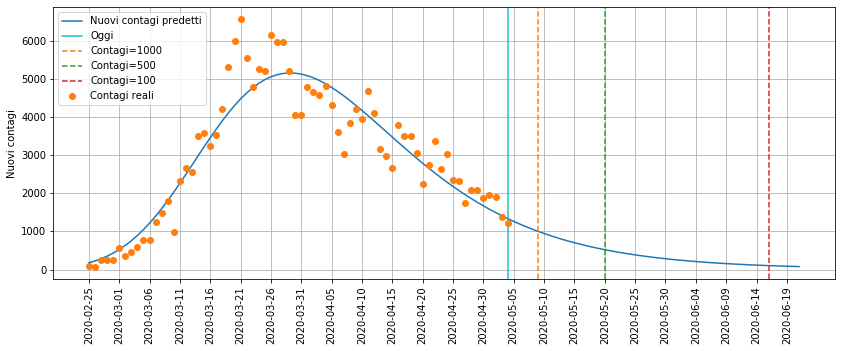

In [21]:
fig,ax=plt.subplots(1,1,figsize=(14,5))
ax.plot(range(max(giorni_soglia)+5),nuovi_contagi_pred[0:max(giorni_soglia)+5],label='Nuovi contagi predetti')
ax.set_ylabel('Nuovi contagi')
ax.axvline(indice_oggi-1,label='Oggi',c=color_names[9])
for i,soglia in enumerate(soglie_contagi):
    ax.axvline(giorni_soglia[i]-1,label='Contagi=%d'%soglia,c=color_names[i+1],linestyle='--')

ax.plot(nuovi_contagi_reali,'o',label='Contagi reali')
#ax.plot(nuovi_contagi_reali_filtered,'+',label='Contagi reali filt.')
    
ax.set_xticks(list(range(0,max(giorni_soglia)+5,5)))
ax.set_xticklabels(str_giorni[list(range(1,len(forecast_days),5))],rotation=90)
ax.grid()
ax.legend()

for i,soglia in enumerate(soglie_contagi):
    print('Soglia: %5d   Giorno: %4d [%10s]'%(soglia,giorni_soglia[i],str_giorni[giorni_soglia[i]]))